![Practicum AI Logo image](https://github.com/PracticumAI/deep_learning_pt-lightning/blob/main/images/practicum_ai_logo.png?raw=1) <img src='https://github.com/PracticumAI/deep_learning_pt-lightning/blob/main/images/practicumai_deep_learning.png?raw=1' alt='Practicum AI: Deep Learning Foundations icon' align='right' width=50>

***
# *Practicum AI:* Deep Learning - MNIST Classifier

This exercise adapted from Baig et al. (2020) <i>The Deep Learning Workshop</i> from <a href="https://www.packtpub.com/product/the-deep-learning-workshop/9781839219856">Packt Publishers</a> (Exercise 2.07, page 92).

## Amelia's AI Adventure Continues...

<img alt="A cartoon of Dr. Amelia's dog looking at a computer with a stack of papers next to it showing some handwritten digits." src="https://github.com/PracticumAI/deep_learning_pt-lightning/blob/main/images/Amelias_Dog_MNIST.jpg?raw=1" padding=20 align="right" width=250>Amelia and her nutrition studies are back! After her adventures with image recognition and binary classification, she's curious to dive deeper.

While Amelia's data collection process is working for most participants in her study, some do not like using the phone application to submit their survey responses. They keep sending in handwritten responses. Realizing that the data from these study participants is still vital to her research, Dr. Amelia is now looking to automate entering these responses using a program to read the numbers that make up the survey responses.

Again, Amelia decides to start with the basics: recognizing handwritten numbers. That's where the MNIST dataset comes in. With its vast collection of handwritten digits, it's the perfect training ground for Amelia's next AI venture.

**Note:** The cartoon of Dr Amelia's dog was generated with AI's assistance.

Training a model on the MNIST dataset is often considered the "Hello world!" of AI. It is a commonly used first introduction to image recognition with deep learning.


![AI Application Development Pathway model](https://github.com/PracticumAI/deep_learning_2_draft/blob/main/M3-AppDev.00_00_22_23.Still001.png?raw=true)

 >&#128221; While you're going through this notebook, see if you can figure out which steps here are associated with each of the steps of the Development Pathway.

## MNIST Handwritten Digit Classification Dataset

The [MNIST](http://yann.lecun.com/exdb/mnist/) (Modified National Institute of Standards and Technology) training dataset contains 60,000 28×28 pixel grayscale images of handwritten single digits between 0 and 9, with an additional 10,000 images available for validation.

The MNIST dataset is frequently used in machine learning research and has become a standard benchmark for image classification models. Top-performing models often achieve a classification accuracy above 99%, with an error rate between 0.4% and 0.2% on the hold-out validation dataset.

In this exercise, you will implement a deep neural network (multi-layer) capable of classifying these images of handwritten digits into one of 10 classes.

Amelia knows that to start any AI project, she'll need the right tools. She begins by importing the necessary libraries to set the stage for her digit-reading neural network.

## 1. Import libraries

Import the necessary libraries.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning import Trainer

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt  # Import the matplotlib library for plotting and visualization.


While the GPU does most of the calculations in training AI models, the CPU of the computer server is responsible for loading images from disk, doing any transformations and sending the data to the GPU. PyTorch takes care of all of this and takes care of doing this in parallel. For maximum GPU performance, multiple cores are needed to constantly feed data to the GPU. The number of workers (num_workers) argument controls how many parallel tasks should be running to load data.

The code block below will detect if your notebook is running in a Slurm job by checking for Slurm environment variables that specify how many CPUs are available and using that information to set the number of workers, if possible. Otherwise, the code checks for the number of cores on your computer and uses that value. To manually set the number of workers, change the first line by adding the value you want to use.

In [2]:
# Set the number of workers to use for data loading
num_workers = None  # To manually set the number of workers, change this to an integer

if num_workers is None:
    # If Slurm is being used, set the number of workers to a Slurm-provided value.
    # If Slurm is not being used, set the number of workers to the number of available CPU cores.
    if os.getenv("SLURM_CPUS_PER_TASK") is not None:
        num_workers = int(os.getenv("SLURM_CPUS_PER_TASK"))
    elif os.getenv("SLURM_NTASKS_PER_NODE") is not None:
        num_workers = int(os.getenv("SLURM_NTASKS_PER_NODE"))
    elif os.getenv("SLURM_NTASKS") is not None:
        num_workers = int(os.getenv("SLURM_NTASKS"))
    else:
        num_workers = os.cpu_count()

print(f"Using {num_workers} workers for data loading.")

Using 3 workers for data loading.


## 2. Load the MNIST dataset

Amelia will need to import the MNIST dataset from PyTorch's [torchvision.datasets module](https://pytorch.org/vision/stable/datasets.html#mnist). The `train_features` and `val_features` variables contain the training and validation images, while `train_labels` and `val_labels` contain the corresponding labels for each item in those datasets.  

Notice that when training with MNIST data, the normalization is different than with the Imagenet data.

In [3]:
# Define transforms to convert PIL images to tensors and normalize
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),  # MNIST mean and std
    ]
)

# Load the MNIST dataset from torchvision
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
val_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

# Extract features and labels for compatibility with visualization parts below
train_features = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()
val_features = val_dataset.data.numpy()
val_labels = val_dataset.targets.numpy()

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:03<00:00, 2.86MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.01MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 8.98MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.92MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## 3. Visualize the data

Before we start to work with data, it is always good to get a better idea of what we are working with.

How many images do we have in our training and validation datasets?

**Note**: We are using the un-transformed `train_features` here. Later, when we train the model, we will use `train_dataset` and a dataloader that will transform the images.

In [4]:
print(f"Training images: {len(train_features)}")
print(f"Validation images: {len(val_features)}")
print(f"Image shape: {train_features[0].shape}")

Training images: 60000
Validation images: 10000
Image shape: (28, 28)


Let's have a look at a random image. You can run this cell multiple times and get a different image each time.

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   5  17   0   0  87 212 222  25   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  36 178 227 161 161 253 252 252  45   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 222 252 252 252 252 247 196 170  13   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 253 252 227 236 210  94   9  13   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 253 231  48  19  12   0   0   0   0   

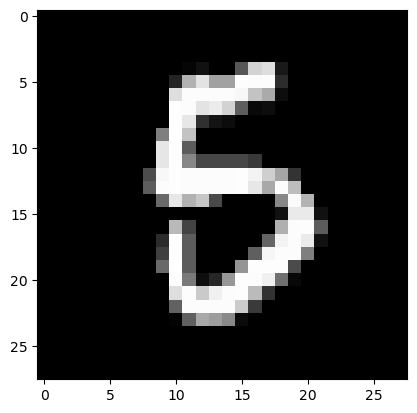

The true label for this image is a 5.


In [10]:
# Set line width for numpy array printing
np.set_printoptions(linewidth=150)

# Select a random number from train_features
select = np.random.randint(0, len(train_features))

# Print the image array - longer line length above should allow it to have all 28 rows in 1 line
print(train_features[select])

# Display the image as an actual image
plt.imshow(train_features[select], cmap="gray")
plt.show()

# Print the true label for the image from train_labels
print(f"The true label for this image is a {train_labels[select]}.")

The output of the cell above should help clarify how images are encoded in our data. Each pixel has a value from 0 (black) to 255 (white). Since our images are black and white, we only have one grid of pixels. For color images, we would have three: one for each color, red, green, blue.

Our datasets have 60,000 images in the `train_features` and 10,000 images in the `val_features`. We will use these data as we move forward.

## 4. Build the sequential model using PyTorch Lightning

Now, the fun part begins! Amelia sets out to build her neural network. In the previous exercises, Amelia called a pre-trained model for image recognition and then built a single-layer network for her binary classifier. With her confidence high, she is going to create this model herself out of multiple layers. This approach gives her (and you!) the most control over the function of the model.

Using PyTorch Lightning, we'll create a model class that encapsulates the neural network architecture and training logic. The model will have the following structure:

* First, add a flattened layer to unroll the 28x28 pixel images into a single array of 784.
* Add a dense hidden layer with 50 units (neurons) and ReLU (Rectified Linear Unit) activation function.
   * The ReLU function will allow the model to capture non-linearity.
* Add a second, dense hidden layer with 20 units and ReLU activation function.
* Add a dense output layer with 10 units and the softmax activation function.
   * We use ten neurons, each representing the digits 0-9.
   * The softmax function ensures the output values are probabilities that sum to 1, making it suitable for classification.

Here's a graphical view of what we are doing:

![A diagram of the neural network being created. It shows the input 28X28 image being flattened into a 784 dimension array. That is the input. There are two hidden, fully connected layers with 50 and 20 neurons each. The final output layer has 10 neurons for the 10 classes in our model.](https://github.com/PracticumAI/deep_learning_pt-lightning/blob/main/images/MNIST_neural_network.png?raw=1)



In [11]:
# Define our model with improved logging for epoch metrics only
class MNISTClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # Define the layers of the model
        self.flatten = nn.Flatten()  # Flatten 28x28 to 784
        self.fc1 = nn.Linear(784, 50)  # 784 inputs to 50 neurons
        self.fc2 = nn.Linear(50, 20)  # 50 outputs to 20 neurons
        self.fc3 = nn.Linear(20, 10)  # 20 to 10 output classes

    def forward(self, x):
        # Define how the data flows through the layers of the model
        # Also add in activation functions and other options
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)  # Log softmax for NLLLoss
        return x

    def training_step(self, batch, batch_idx):
        # Define how the model is trained
        x, y = batch
        y_hat = self(x)
        loss = F.nll_loss(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()

        # Log training metrics
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.nll_loss(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()

        # Log validation metrics
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        return {"val_loss": loss, "val_acc": acc}

    def configure_optimizers(self):
        # Define the optimizer and learning rate
        return optim.Adam(self.parameters(), lr=0.001)


# Instantiate the model
model = MNISTClassifier()

## 5. Prepare the data loaders

In PyTorch, we need to create data loaders to efficiently batch and iterate through our data during training. PyTorch Lightning works seamlessly with PyTorch's DataLoader.

The `num_workers` variable was set above and controls the number of CPUs that will be used to load and process the data.

In [12]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, 
                        num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False,
                        num_workers=num_workers)


## 6. Inspect the model configuration using print

Display a summary of the model's architecture, including the layers, their shapes, and the number of parameters.


In [13]:
print(model)

# Count the total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params}")

MNISTClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
)

Total parameters: 40480


The model summary indicates that this model has 40,480 parameters (weights and biases). **Note**: If your model does not show `Total parameters: 40480`, double check your model was set up correctly.

## 7. Train the model using PyTorch Lightning

Now, train the model on the MNIST dataset using PyTorch Lightning's `Trainer`. We'll set the training to run for 10 epochs.

Train the model using the training data:
* `train_loader`: the DataLoader containing input images and labels
* `max_epochs=10`: the number of times the model will cycle through the entire dataset

```python
# Create a PyTorch Lightning trainer
trainer = Trainer(max_epochs=10, enable_progress_bar=True)

# Train the model
trainer.fit(model, train_loader, val_loader)
```

In [14]:
# Code it!
trainer = Trainer(max_epochs=10, enable_progress_bar=True)
trainer.fit(model, train_loader, val_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/project/scinet_workshop1/deep_learning_foundations/dlf_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA A100-SXM4-80GB MIG 1g.10gb') that has Tensor Cores. To properly utili

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## 8. Evaluate the model

Finally, evaluate your model's performance on the validation set.

In [17]:
trainer.validate(model, dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-0659bea7-b666-5f99-af0d-121ac0b040cb]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_acc_epoch         0.9696000218391418
     val_loss_epoch         0.1039598286151886
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss_epoch': 0.1039598286151886, 'val_acc_epoch': 0.9696000218391418}]

## 9. Model predictions

Let's see how the model performs on some randomly selected images.  Are its predictions correct?  

Randomly select an image from the validation dataset, in this case, the 200th image.

Select a specific image from the validation dataset for examination or prediction.

The variable `loc` is set to the index 200, which means we are selecting the 201st image (0-based index) from the validation dataset.

```python
loc = 200

# Extract the corresponding image from the val_features array and store it in the 'val_image' variable.
val_image = val_features[loc]
```

In [19]:
# Code it!
loc=200
val_image = val_features[loc]

First, let's take a look at the shape of the image.

* Get and display the shape (dimensions) of the `val_image` variable.
* This provides insight into the structure and size of the image.

```python
val_image.shape
```

In [20]:
# Code it!
val_image.shape

(28, 28)

We see that our image is 28x28 pixels. However, the model needs not just the size of the image but also the batch dimension. A simple call to the `reshape()` method or `unsqueeze()` fixes that problem.

* Reshape the `val_image` from a 2D array (28x28) to a 3D array (1x28x28).
* This is commonly done to match the input shape that the model expects when making predictions on single samples.

```python
val_image_tensor = torch.tensor(val_image, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
```

In [21]:
# Code it!
val_image_tensor = torch.tensor(val_image, dtype=torch.float32).unsqueeze(0)

Now call the model's forward pass to make a prediction, assign the output to result, and then view its contents.

* Use the trained model to predict the label for the `val_image_tensor`.
* The model returns log probabilities, so we'll convert them to probabilities and display both.
* Each value in the array corresponds to the model's predicted probability that the image belongs to a particular class (digit).


In [22]:
model.eval()
with torch.no_grad():
    result = model(val_image_tensor)
    probabilities = torch.exp(result)  # Convert log probabilities to probabilities

# Print the array of probabilities to the console.
print("Log probabilities:", result)
print("Probabilities:", probabilities)

Log probabilities: tensor([[-2361.4133, -1674.8225, -1056.2993,     0.0000, -2788.3066,  -794.8698,
         -2465.8232, -2382.7109, -1248.7428, -1315.2507]])
Probabilities: tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])


As we see, the model has returned the probability of 10 predictions, with the highest one being the most likely.  Use the `argmax` function to see the model's prediction.

* Use the `argmax` method to find the index (label) of the maximum value in the `result` tensor.
   * This gives us the model's most likely prediction for the class (digit) of the `val_image`.

```python
predicted_digit = result.argmax(dim=1).item()
print(f"Predicted digit: {predicted_digit}")
```

In [24]:
# Code it!
predicted_digit = result.argmax(dim=1).item()
print(f"Predicted digit: {predicted_digit}")

Predicted digit: 3


To verify the prediction, check the label of the corresponding image.

* Using the index loc, retrieve the true label (actual digit) for the `val_image` from the `val_labels` array.
   * This gives us the actual class (digit) of the `val_image` to compare with the model's prediction.

```python
true_digit = val_labels[loc]
print(f"True digit: {true_digit}")
```

In [25]:
# Code it!
true_digit = val_labels[loc]
print(f"True digit: {true_digit}")

True digit: 3


Finally, visualize the image with pyplot.

* Use the `imshow` function from the `matplotlib` library to display the `val_image` as a visual image.
   * This helps in visually examining the content of the `val_image` (which is represented as a 28x28 array of pixel values).


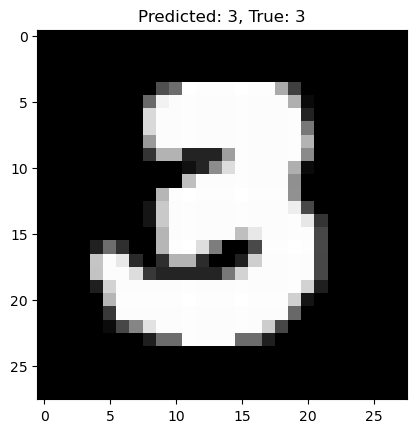

In [26]:
plt.imshow(val_features[loc], cmap="gray")
plt.title(f"Predicted: {predicted_digit}, True: {true_digit}")
plt.show()

And we did it! We helped Amelia create a model that can recognize handwritten digits!


## Bonus exercise

* Write a function that ties all these steps into one function call. The function should take an input image and print the image with the predicted digit and true digit.

In [27]:
import torch
import matplotlib.pyplot as plt

def show_prediction(model, dataset, index):
    """
    Show an MNIST image with predicted and true digit.

    Parameters
    ----------
    model : trained PyTorch Lightning model
        e.g. an instance of MNISTClassifier after training.
    dataset : torchvision.datasets.MNIST
        The dataset to pull images/labels from (train_dataset or val_dataset).
    index : int
        The index of the image to display.
    """

    # Put model in evaluation mode
    model.eval()

    # Get the image and label
    image, true_label = dataset[index]

    # Add batch dimension and run through model
    with torch.no_grad():
        output = model(image.unsqueeze(0))   # shape [1, 10]
        pred_label = torch.argmax(output, dim=1).item()

    # Plot image with labels
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f"Predicted: {pred_label}, True: {true_label}")
    plt.axis("off")
    plt.show()

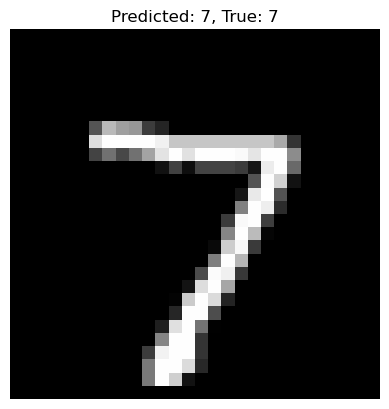

In [28]:
show_prediction(model, val_dataset, index=0)

## Before continuing
###  <img src='https://github.com/PracticumAI/deep_learning_pt-lightning/blob/main/images/alert_icon.svg?raw=1' alt="Alert icon" width=40 align=center> Alert!
> Before continuing to another notebook within the same Jupyter session,
> use the **"Running Terminals and Kernels" tab** (below the File Browser tab) to **shut down this kernel**.
> This will free up this notebook's GPU memory, making it available for
> your next notebook.
>
> Every time you run multiple notebooks within a Jupyter session with a GPU, this should be done.
>
> ![Screenshot of the Running Terminals and Kernels tab used t oshut down kernels before starting a new notebook](https://github.com/PracticumAI/deep_learning_pt-lightning/blob/main/images/stop_kernel.png?raw=1)

----
## Push changes to GitHub <img src="https://github.com/PracticumAI/deep_learning_pt-lightning/blob/main/images/push_to_github.png?raw=1" alt="Push to GitHub icon" align="right" width=150>

 Remember to **add**, **commit**, and **push** the changes you have made to this notebook to GitHub to keep your repository in sync.

In Jupyter, those are done in the git tab on the left. In Google Colab, use File > Save a copy in GitHub.
